In [1]:
import numpy as np
import geopandas as gpd
from scipy.spatial import KDTree
from tqdm.autonotebook import tqdm
from scipy.ndimage import gaussian_filter
from fuzzywuzzy import process
import contextily as cx

from IndexUtils import * 
from TileUtils import *

# TILED INFERENCE
import sahi
from sahi import AutoDetectionModel
from sahi.predict import get_sliced_prediction, predict
from scipy.spatial.distance import cdist

import numpy as np
from scipy.fftpack import fft2, ifft2, fftshift
from scipy.ndimage import center_of_mass



C:\Users\fhacesga\AppData\Local\Temp\ipykernel_27308\960495920.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


WARNING  Python>=3.10 is required, but Python==3.8.18 is currently installed 


In [2]:
# corners = gpd.read_file(r"C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\AAA_ReferenceDatasets\OSM_Roads\TexasRoads_filtered_strict_3857_nondupe_smaller_harris.gpkg")
corners = gpd.read_file(r"C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\AAA_ReferenceDatasets\OSM_Roads\TexasRoads_filtered_strict_3857_nondupe_smaller_harris.gpkg")

In [3]:
with open("SmartDictV2.p", 'rb') as f:
    tile_coords = pickle.load(f)

In [4]:
with open(r"D:\RECTDNN\processing\2024-10-11_15-08-46\street_corners\exp7\pickles\48201C0660L.pickle", 'rb') as f:
    x = pickle.load(f)    
    corner_bbox = [a.bbox.to_xyxy() for a in x if a.score.value > 0.001]
    corner_arry = np.array([calcCenter(a) for a in corner_bbox ]) * 2
    print(f"{len(corner_bbox)} / {len(x)}")

1331 / 1331


In [5]:
# r"D:\RECTDNN\processing\2024-10-11_15-08-46\referencing\48201C0930J.tif"
im_file    = r"D:\RECTDNN\processing\2024-10-11_15-08-46\referencing\48201C0660L.tif"
him_file   = r"D:\RECTDNN\processing\2024-10-11_15-08-46\half_size\48201C0660L.tif"

curr_tn = os.path.basename(im_file.split(".")[0])[:-1]
curr_tf = os.path.basename(im_file.split(".")[0])[-1]

ra = rio.open(im_file)
bounds  = ra.bounds
image   = ra.read(1)

bounds, RLNN = findBounds(im_file, None)
bbox = bounds[0].boxes.xyxy.numpy().astype(np.int32)[0].flatten()

real_x, real_y = bbox_to_coords_realworld(tile_coords[curr_tn][curr_tf]["coords"][0])
pic_x, pic_y   = bbox_to_coords_raster(bbox)

affine = affineTransformation(pic_x, pic_y, real_x, real_y)

# corner_arry = streetcorners[os.path.basename(tile).split(".")[0] + ".pickle"] * 2# streetresults_struct[tile_coords[out_name]['input_file']]
corner_arry = np.int32(corner_arry)                 # CONVERT TO INT32
corner_arry = cleanCenterBBOX(corner_arry, bbox)

# USE RASTER TRANSFORM TO GET REAL-WORLD ESTIMATES OF STREET CORNERS
corner_gdf = pointsToGeodataFrame(ra, corner_arry[:, 1], corner_arry[:, 0])

bounds_poly = enlarged_bounds(ra, n=2)

In [6]:
def calculate_azimuths(points, target):
    # Calculate the azimuths in a vectorized manner
    dx, dy = points[:, 0] - target[0], points[:, 1] - target[1]
    azimuths = np.degrees(np.arctan2(dy, dx)) % 360
    return azimuths

def azimuthDescriptors(coords, angle_step=30, start_angle=None, search_radius=50, overlap=True):

    divisor = 1 if overlap else 2

    if start_angle is None:
        azimuth_ranges = [(i - angle_step / 2, i + angle_step / 2) for i in np.arange(0, 360, angle_step // divisor)]
    else:
        azimuth_ranges = [(i, i + angle_step) for i in np.arange(start_angle, start_angle+360, angle_step // divisor)]
    kdtree = KDTree(coords)  # Efficient nearest neighbor search
    results = []

    for i, point in tqdm(enumerate(coords), total=coords.shape[0], leave=False):
        point_results = []
        
        # Get points within the search radius around the current point
        indices = kdtree.query_ball_point(point, r=search_radius)
        neighbor_coords = coords[indices]
        
        # Vectorized azimuth calculation for neighbors
        azimuths = calculate_azimuths(neighbor_coords, point)
        distances = np.linalg.norm(neighbor_coords - point, axis=1)
        
        for min_az, max_az in azimuth_ranges:
            # Filter indices based on azimuth range
            mask = (azimuths >= min_az) & (azimuths <= max_az)
            filtered_distances = distances[mask]
            filtered_neighbors = neighbor_coords[mask]
            
            if filtered_neighbors.size > 0:
                # Find the closest point within the filtered neighbors
                # min_dist_idx = np.argmin(filtered_distances)
                # closest_point = filtered_neighbors[min_dist_idx]
                # min_distance = filtered_distances[min_dist_idx]
                # point_results.append((closest_point, min_distance))
                point_results.append(np.mean(filtered_distances))
                # point_results.append(min_distance)
            else:
                point_results.append(-1 * search_radius)
                # point_results.append((None, None))  # No point in range

        point_results = 1 - np.array(point_results) / search_radius
        results.append(point_results)
    return results

def bboxTransformToCRS(transform, image):
    rev_y_axis = np.array([[1, 0, 0],
                        [0,-1, 0],
                        [0, 0, 1]])
    
    translation = np.eye(3)
    translation[1, 2] = image.shape[0]

    return transform @ translation @ rev_y_axis

def bbox_to_coords_realworld(bbox):
    # BOUNDING BOX 

    x_min, y_min, x_max, y_max = bbox

    xs = [x_min, x_min, x_max, x_max]
    ys = [y_max, y_min, y_min, y_max]
    return xs, ys

def bbox_to_coords_raster(bbox):
    # BOUNDING BOX 

    x_min, y_min, x_max, y_max = bbox

    xs = [x_min, x_min, x_max, x_max]
    ys = [y_min, y_max, y_max, y_min]
    return xs, ys

In [7]:
r'''detection_model = AutoDetectionModel.from_pretrained(
        model_type="yolov8",
        model_path=r"C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\FANN\FANN_large_YOLO.pt",
        confidence_threshold=0.01,
        device="cuda",  # or 'cuda:0'
    )
    
result = predict(source=him_file, # source=processing_images[0], # source=half_path, 
                detection_model=detection_model, 
                verbose=2, 
                project=r"D:\RECTDNN\processing\2024-10-11_15-08-46\street_corners\\",
                slice_height=256, 
                slice_width=256, 
                model_device="cuda", 
                return_dict=True, 
                export_pickle=True,
                visual_hide_labels=True)'''

'detection_model = AutoDetectionModel.from_pretrained(\n        model_type="yolov8",\n        model_path=r"C:\\Users\\fhacesga\\OneDrive - University Of Houston\\AAA_RECTDNN\\data\\FANN\\FANN_large_YOLO.pt",\n        confidence_threshold=0.01,\n        device="cuda",  # or \'cuda:0\'\n    )\n    \nresult = predict(source=him_file, # source=processing_images[0], # source=half_path, \n                detection_model=detection_model, \n                verbose=2, \n                project=r"D:\\RECTDNN\\processing\\2024-10-11_15-08-46\\street_corners\\\\",\n                slice_height=256, \n                slice_width=256, \n                model_device="cuda", \n                return_dict=True, \n                export_pickle=True,\n                visual_hide_labels=True)'

In [8]:
r''' 
transform = bboxTransformToCRS(affine.matrix, image)
with rio.open("testgeoreference2.tif", 'w',
    driver='GTiff', count=1, dtype=image.dtype,
    height=image.shape[0], width=image.shape[1],
    crs=f'EPSG:3857',
    transform=rio.Affine(*transform.flatten()[:6])) as dst:
        dst.write(image, 1)'''

' \ntransform = bboxTransformToCRS(affine.matrix, image)\nwith rio.open("testgeoreference2.tif", \'w\',\n    driver=\'GTiff\', count=1, dtype=image.dtype,\n    height=image.shape[0], width=image.shape[1],\n    crs=f\'EPSG:3857\',\n    transform=rio.Affine(*transform.flatten()[:6])) as dst:\n        dst.write(image, 1)'

In [9]:
corners_curr = gpd.clip(corners, bounds_poly)

In [56]:
def match_descriptors(reference_descriptors, target_descriptors, ratio_threshold=0.75, dist_thresh=2):
    """
    Matches descriptors using Euclidean distance and applies the Lowe ratio test.
    
    Args:
    reference_descriptors (ndarray): Descriptors from the reference image (n_ref x d).
    target_descriptors (ndarray): Descriptors from the target image (n_target x d).
    ratio_threshold (float): The threshold for the Lowe ratio test (default is 0.75).
    
    Returns:
    list of (ref_idx, tgt_idx) matches that pass the Lowe ratio test.
    """
    
    # Number of reference and target descriptors
    n_ref = reference_descriptors.shape[0]
    n_target = target_descriptors.shape[0]

    # Array to store matches
    matches = []
    
    # Vectorized distance calculation
    # Compute all pairwise distances between reference and target descriptors
    # This uses broadcasting to compute the Euclidean distances efficiently
    # dist_matrix will be of shape (n_ref, n_target)
    # dist_matrix = np.linalg.norm(reference_descriptors[:, np.newaxis, :] - target_descriptors[np.newaxis, :, :], axis=2)
    dist_matrix = cdist(reference_descriptors, target_descriptors, metric='cosine')
    
    # For each descriptor in the reference set
    for ref_idx in tqdm(range(n_ref), leave=False):
        # Sort the distances to find the two smallest distances
        sorted_indices = np.argsort(dist_matrix[ref_idx])
        closest_idx = sorted_indices[0]  # Closest descriptor in the target set
        second_closest_idx = sorted_indices[1]  # Second closest
        
        # Compute the distances to the two closest target descriptors
        d1 = dist_matrix[ref_idx, closest_idx]
        d2 = dist_matrix[ref_idx, second_closest_idx]

        
        # Apply the Lowe ratio test
        if d1 / d2 < ratio_threshold:
            # If the ratio passes the threshold, store the match (ref_idx, closest_idx)
            if d1 < dist_thresh and d2 < dist_thresh: 
                matches.append((ref_idx, closest_idx, d1, d2))
    
    return matches

def tryMatchingWithParams(angle_step=10, search_radius=2000, ratio_threshold=0.8):
    # ALL STREETS AZIMUTHS (ONLY NEED TO DO ONCE AND SAVE)
    # corners[['descriptors' + str(i) for i in range(np.array(azimuth_distances).shape[1])]] = np.array(azimuth_distances)\
    corners_curr = gpd.clip(corners, bounds_poly)
    coords = np.vstack((np.array(corners_curr.geometry.x), np.array(corners_curr.geometry.y))).T
    azimuth_distances = azimuthDescriptors(coords, angle_step=angle_step, search_radius=search_radius, overlap=True)
    descriptors_curr = np.array(azimuth_distances)

    corners_curr[['descriptors' + str(i) for i in range(np.array(azimuth_distances).shape[1])]] = np.array(azimuth_distances)

    # ALL STREETS AZIMUTHS (ONLY NEED TO DO ONCE AND SAVE)
    coords = np.vstack((np.array(corner_gdf.geometry.x), np.array(corner_gdf.geometry.y))).T
    azimuth_distances_curr = azimuthDescriptors(coords, angle_step=angle_step, search_radius=search_radius, overlap=True)

    corner_gdf[['descriptors' + str(i) for i in  range(np.array(azimuth_distances_curr).shape[1])]] = np.array(azimuth_distances_curr)

    out = match_descriptors( np.array(azimuth_distances_curr), np.array(azimuth_distances), ratio_threshold=ratio_threshold)

    return out, descriptors_curr, corner_gdf, corners, corners_curr

In [160]:
out, _, corner_gdf_curr, corners, corners_curr = tryMatchingWithParams(angle_step=5, search_radius=500, ratio_threshold=0.95)

  0%|          | 0/13178 [00:00<?, ?it/s]

  0%|          | 0/1280 [00:00<?, ?it/s]

  0%|          | 0/1280 [00:00<?, ?it/s]

In [161]:
def calcQuiver(ax, fromGDF, toGDF, color="black"):
    fromcoords = np.vstack((np.array(fromGDF.geometry.x), np.array(fromGDF.geometry.y))).T
    tocoords = np.vstack((np.array(toGDF.geometry.x), np.array(toGDF.geometry.y))).T

    uv = tocoords - fromcoords
    ax.quiver(fromcoords[:, 0], fromcoords[:, 1], uv[:, 0], uv[:, 1], angles='xy', color=color)

    return ax, uv

def normArry(arry):
    return (arry - np.min(arry)) / (np.max(arry) - np.min(arry))



In [162]:
from sklearn.cluster import DBSCAN
import numpy as np

def most_popular_indices(values, eps=0.1):
    # Convert values to a 2D array as required by DBSCAN
    values_2d = np.array(values).reshape(-1, 1)
    
    # Cluster the values using DBSCAN
    db = DBSCAN(eps=eps, min_samples=2).fit(values_2d)
    
    # Find the most common cluster label, ignoring noise (-1 label)
    labels, counts = np.unique(db.labels_[db.labels_ != -1], return_counts=True)
    if len(counts) == 0:
        return []  # No clusters found
    
    most_common_label = labels[np.argmax(counts)]
    
    # Get indices of values in the most common cluster
    indices = [i for i, label in enumerate(db.labels_) if label == most_common_label]
    
    return indices

def most_popular_indices_2d(points, eps=0.1):
    # Convert the list of 2D points to a numpy array
    points_array = np.array(points)
    
    # Cluster the points using DBSCAN
    db = DBSCAN(eps=eps, min_samples=2).fit(points_array)
    
    # Find the most common cluster label, ignoring noise (-1 label)
    labels, counts = np.unique(db.labels_[db.labels_ != -1], return_counts=True)
    if len(counts) == 0:
        return []  # No clusters found
    
    most_common_label = labels[np.argmax(counts)]
    
    # Get indices of points in the most common cluster
    indices = [i for i, label in enumerate(db.labels_) if label == most_common_label]
    
    return indices

46


(array([          0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,
                  0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,
                  0,           0,           0,           8,          14,          23,           0,           1,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,
                  0,           0,       

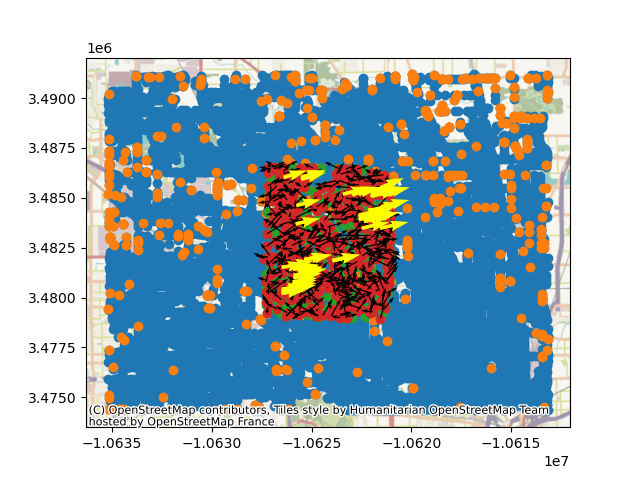

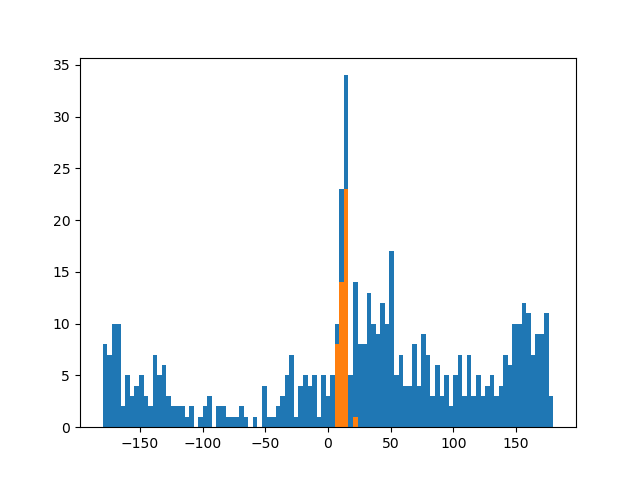

In [175]:
%matplotlib widget
ax = corners_curr.plot()
corners_curr.iloc[np.array(out)[:, 1]].plot(ax=ax)
corner_gdf.plot(ax=ax)
corner_gdf.iloc[np.array(out)[:, 0]].plot(ax=ax)

ax, uv = calcQuiver(ax, corner_gdf.iloc[np.array(out)[:, 0]], corners_curr.iloc[np.array(out)[:, 1]])

ax.quiver
cx.add_basemap(ax)


angles = np.degrees(np.arctan2(uv[:, 1], uv[:, 0]))
test = np.vstack((normArry(angles), normArry(np.sqrt(uv[:, 0] ** 2, uv[:, 1] ** 2 )))).T
idx = most_popular_indices_2d(test, eps=0.02)

ax, uv = calcQuiver(ax, corner_gdf.iloc[np.array(out)[idx, 0]], corners_curr.iloc[np.array(out)[idx, 1]], color="yellow")

print(len(idx))

bins = np.linspace(-180, 180, 100)

fig, ax = plt.subplots()
ax.hist(angles, bins)
ax.hist(angles[idx], bins)

In [364]:
corner_gdf.to_file("testout1.shp")
corner_gdf.iloc[np.array(out)[idx, 0]].to_file("testout.shp")

10/30/2024 10:21:15 - WARNING - fiona._env -   Normalized/laundered field name: 'descriptors0' to 'descriptor'
10/30/2024 10:21:15 - WARNING - fiona._env -   Normalized/laundered field name: 'descriptors1' to 'descript_1'
10/30/2024 10:21:15 - WARNING - fiona._env -   Normalized/laundered field name: 'descriptors2' to 'descript_2'
10/30/2024 10:21:15 - WARNING - fiona._env -   Normalized/laundered field name: 'descriptors3' to 'descript_3'
10/30/2024 10:21:15 - WARNING - fiona._env -   Normalized/laundered field name: 'descriptors4' to 'descript_4'
10/30/2024 10:21:15 - WARNING - fiona._env -   Normalized/laundered field name: 'descriptors5' to 'descript_5'
10/30/2024 10:21:15 - WARNING - fiona._env -   Normalized/laundered field name: 'descriptors6' to 'descript_6'
10/30/2024 10:21:15 - WARNING - fiona._env -   Normalized/laundered field name: 'descriptors7' to 'descript_7'
10/30/2024 10:21:15 - WARNING - fiona._env -   Normalized/laundered field name: 'descriptors8' to 'descript_8'
1

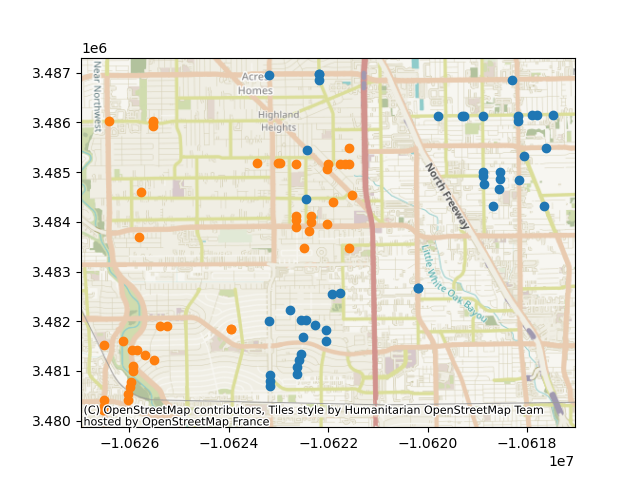

In [365]:
ax = corners_curr.iloc[np.array(out)[idx, 1]].plot()
corner_gdf.iloc[np.array(out)[idx, 0]].plot(ax=ax)

cx.add_basemap(ax)

In [177]:
coordsA = np.vstack((np.array(corners_curr.iloc[np.array(out)[idx, 1]].geometry.x), np.array(corners_curr.iloc[np.array(out)[idx, 1]].geometry.y))).T
coordsB = np.vstack((np.array(corner_gdf.iloc[np.array(out)[idx, 0]].geometry.x), np.array(corner_gdf.iloc[np.array(out)[idx, 0]].geometry.y))).T

def normCoords(A, B):
    offsets = np.mean(A, axis=0)
    return A - offsets, B - offsets

coordsA, coordsB = normCoords(coordsA, coordsB)

15

In [346]:
initial = similarityTransformation(coordsA[:, 0], coordsA[:, 1], coordsB[:, 0], coordsB[:, 1],verbose=False)
matrix = initial.matrix

print(matrix)
print(np.linalg.inv(matrix))
"""matrix[0, 0] = 1
matrix[1, 1] = 1
matrix[0, 1] = 0
matrix[1, 0] = 0
# matrix[1, 2] = matrix[1, 2] * -1"""




[[    0.90818    0.012944     -3594.4]
 [  -0.012944     0.90818     -790.99]
 [          0           0           1]]
[[     1.1009    -0.01569      3944.6]
 [    0.01569      1.1009      927.19]
 [          0           0           1]]


'matrix[0, 0] = 1\nmatrix[1, 1] = 1\nmatrix[0, 1] = 0\nmatrix[1, 0] = 0\n# matrix[1, 2] = matrix[1, 2] * -1'

In [420]:
coordsB[idx]

array([[      -2077,      81.166],
       [    -2084.7,      5.6368],
       [    -4676.9,     -2132.2],
       [    -4968.2,      1966.1],
       [    -5351.9,     -2931.8],
       [    -2074.6,      1131.2],
       [    -1784.1,     -49.368],
       [    -2079.3,      -140.5],
       [    -1930.9,     -568.22],
       [    -1783.3,      77.883],
       [    -4965.9,      1883.2],
       [    -5952.4,     -3741.3],
       [    -5564.8,     -2430.2],
       [    -5239.3,     -352.31],
       [    -964.58,      504.79],
       [    -5125.9,     -2724.9],
       [    -1817.5,     -229.98],
       [    -5379.1,     -2623.1],
       [    -1446.2,      1123.8]])

In [424]:
def get_non_outlier_indices(data, threshold=2):
    """
    Detects non-outlier indices based on a standard deviation threshold.

    Parameters:
    - data (array-like): The data array to check.
    - threshold (float): The number of standard deviations to use as the cutoff.

    Returns:
    - non_outlier_indices (numpy array): Indices of the data points that are not outliers.
    """
    # Calculate mean and standard deviation
    mean = np.mean(data)
    std_dev = np.std(data)
    
    # Determine which points are within the threshold
    non_outliers = np.abs(data - mean) <= threshold * std_dev
    print(mean, threshold * std_dev)
    
    # Return indices of non-outliers
    return np.where(non_outliers)[0]

checker = True
idx  = np.ones(coordsB.shape[0], dtype=np.int32)
prev = np.where(idx)[0].shape[0]


while checker:

    coordsBprime = np.hstack((coordsB[idx], np.ones((coordsB[idx].shape[0], 1)))) @ np.linalg.inv(matrix).T
    """
    fig, axs = plt.subplots(1, 2)
    axs[0].scatter(coordsA[idx, 0], coordsA[idx, 1], color='black')
    axs[0].scatter(coordsB[idx, 0], coordsB[idx, 1])
    axs[0].scatter(coordsBprime[:, 0], coordsBprime[:, 1], marker='x')"""

    distances = np.sqrt((coordsBprime[:, 0] - coordsA[idx, 0]) ** 2 + (coordsBprime[:, 1] - coordsA[idx, 1]) ** 2)
    # axs[1].hist(distances, bins=50)

    idx = get_non_outlier_indices(distances, threshold=3)
    print(distances[~idx])

    if np.where(idx)[0].shape[0] < prev:
        prev =  np.where(idx)[0].shape[0]
    else: 
        checker=False

    print(prev)
    # plt.show()
    

45.60033344248626 4.263256414560601e-14
[       45.6        45.6        45.6        45.6        45.6        45.6        45.6        45.6        45.6        45.6        45.6        45.6        45.6        45.6        45.6        45.6        45.6        45.6        45.6        45.6        45.6        45.6        45.6        45.6        45.6        45.6
        45.6        45.6        45.6        45.6        45.6        45.6        45.6        45.6        45.6        45.6        45.6        45.6        45.6        45.6        45.6        45.6        45.6        45.6        45.6        45.6]
45
96.06947778437012 311.11153768702286
[     93.668      56.028      62.735      208.08      196.51      74.053      135.15       47.97      60.592      75.941      37.838      69.575      72.749       109.6      44.904      65.751      68.342      65.069      620.33       55.76      65.191      55.503      55.824      265.01      130.03       422.3
      54.578      49.244      46.606       68.03    

In [397]:
flip=np.array([
    [1, 0, 0],
    [0, -1, 0],
    [0, 0, 1]
    ]) 

""" THIS KINDA WORKS BUT DAMMIT WE'RE GONNA GET IT PERFECT. 
rev_adj = np.linalg.inv(matrix)
rev_adj[1, 2] = rev_adj[1, 2] * -1
print(rev_adj)"""

rev_adj = np.linalg.inv(matrix) @ flip
print(rev_adj)

output_transform = getMatrixFromAffine(ra.transform) @ rev_adj

with rio.open("test_georeference0.tif", 'w',
                driver='GTiff', count=1, dtype=np.uint8,
                height=image.shape[0], width=image.shape[1],
                crs=f'EPSG:3857',
                transform=rio.Affine(*output_transform.flatten()[:6])) as dst:
                    dst.write(image, 1) 

10/30/2024 10:43:51 - INFO - rasterio._env -   GDAL signalled an error: err_no=1, msg='Deleting test_georeference0.tif failed:\nPermission denied'


[[     1.1009    -0.01569      3944.6]
 [    0.01569      1.1009     -927.19]
 [          0           0           1]]


CPLE_AppDefinedError: Deleting test_georeference0.tif failed: Permission denied